<a href="https://colab.research.google.com/github/Ikar108/Gradient_Descent/blob/main/Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from copy import deepcopy
import random

In [2]:
def func1(X):
  return 0.1 * X[0]**2 + 0.2 * X[1]**2

def func2(X):
  return 10 * X[0]**2 + 0.2 * X[1]**2

def func3(X):
  return 100 * X[0]**2 + 200 * X[1]**2


def func4(X):
  return 2 * X[0]**2

def func5(X):
  return X[0]**2 * X[1]**2 + abs(X[0]) + abs(X[1])

def func6(X):
  return 10 * X[0]**2 - 4.2 * X[0] + X[1]**2 + 0.1 * X[2]**2 + 8 * X[2] + 3

In [13]:
class Descent:

  def __init__(self):
    self.L = 0.5
    self.eps = 1e-8

  def grad(self, function, X):
    grad = np.empty(len(X),float)

    for i in range(len(X)):
      X[i] = X[i] + self.eps
      grad[i] = function(X)
      X[i] = X[i] - 2 * self.eps
      grad[i] = (grad[i] - function(X)) / 2 / self.eps
      X[i] = X[i] + self.eps

    return grad

  def hessian(self, function, X):
    hess = np.empty((len(X),len(X)),float)

    loc_eps = 1e-3

    for i in range(len(X)):
      for j in range (len(X)):    
        
        X[i] = X[i] + loc_eps

        X[j] = X[j] + loc_eps
        df0 = function(X)
        X[j] = X[j] - 2 * loc_eps
        df0 = (df0 - function(X)) / 2 / loc_eps
        X[j] = X[j] + loc_eps

        X[i] = X[i] - 2 * loc_eps

        X[j] = X[j] + loc_eps
        df1 = function(X)
        X[j] = X[j] - 2 * loc_eps
        df1 = (df1 - function(X)) / 2 / loc_eps
        X[j] = X[j] + loc_eps

        X[i] = X[i] + loc_eps

        hess[i, j] = (df0 - df1) / 2 / loc_eps

    return hess
  
  def round_eps(self, x):
    x_round = round(x, 4)
    return x if (abs(x - x_round) > 1000 * self.eps) else x_round

  def round_eps_array(self, X):
    X_round = np.array([self.round_eps(x) for x in X])
    return X_round

  def const_step(self, f, X, direction):
    return X - 2/self.L * direction

  def division_step(self, f, X, direction):
    temp_rate = 20/self.L

    while f(X - temp_rate * direction) > f(X) - 0.1 * temp_rate * (direction @ direction):
      temp_rate *= 0.9

    return X - temp_rate * direction

  def golden_ratio_step(self, f, X, direction):
    a, b = X, X - 200/self.L * direction
    phi = (np.sqrt(5) - 1) / 2

    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)

    f1 = f(x1)
    f2 = f(x2)

    while (np.linalg.norm(b - a) > self.eps):
      if (f1 - f2) > 0:
        a = x1
        x1 = x2
        f1 = f2
        x2 = a + phi * (b - a)
        f2 = f(x2)
      else:
        b = x2
        x2 = x1
        f2 = f1
        x1 = b - phi * (b - a)
        f1 = f(x1)

    return (a + b) / 2

  def fibonacci(self, m):
    fib_curr = 1
    fib_prev = 1
    fib_arr  = [1,1]

    while(fib_curr < m):
        fib_arr.append(fib_curr)
        fib_curr += fib_prev
        fib_prev = fib_arr[len(fib_arr) - 1]

    fib_arr.append(fib_curr)
    return fib_arr

  def fibonacci_step(self, f, X, direction):
      a, b = X, X - 2/self.L * direction
      m = 2/self.L * np.linalg.norm(direction) / self.eps

      fibonacci = self.fibonacci(m)
      n = len(fibonacci) - 3

      x1 = a + fibonacci[n] / fibonacci[n + 2] * (b - a)
      x2 = a + fibonacci[n + 1] / fibonacci[n + 2] * (b - a)

      f1 = f(x1);
      f2 = f(x2);

      prev_len = 1
      iter = 0

      while (np.linalg.norm(b - a) > self.eps):      
        prev_len = b - a
        iter += 1

        if (f1 - f2) > 0:
          a = x1
          x1 = x2
          f1 = f2
          x2 = a + fibonacci[n - iter + 2] / fibonacci[n - iter + 3] * (b - a)
          f2 = f(x2);
        else:
          b = x2;
          x2 = x1;
          f2 = f1;
          x1 = a + fibonacci[n - iter + 1] / fibonacci[n - iter + 3] * (b - a)
          f1 = f(x1);
          
      return (a + b) / 2;



  def fast(self, f, X, step):
    if step == 'const':
      self.step = self.const_step
    elif step == 'golden':
      self.step = self.golden_ratio_step
    elif step == 'fibonacci':
      self.step = self.fibonacci_step
    else:
      raise Exception("Wrong step type")

    counter = 1 # счётчик вычислений градиента

    X = np.array(X).astype(float)
    path = [X]

    last_X = deepcopy(X)
    last_X[0] = last_X[0] + 1
    d_X = self.grad(f, X)
    self.L = np.linalg.norm(d_X)

    while(max(abs(X - last_X)) > self.eps) and np.linalg.norm(d_X) != 0:
      counter += 1

      last_X = deepcopy(X)
      d_X = self.grad(f, X)
      self.L = max(self.L, np.linalg.norm(d_X))
      X = self.step(f, X, d_X)
      d_f = f(X) - f(last_X)

      while(d_f < 0):
        path.append(X.tolist())
        loc_last_X = deepcopy(X)
        X = self.step(f, X, d_X)
        d_f = f(X) - f(loc_last_X)

    return self.round_eps_array(X), path, counter



  def gradient(self, f, X, step):
    if step == 'const':
      self.step = self.const_step
    elif step == 'div':
      self.step = self.division_step
    else:
      raise Exception("Wrong step type")

    counter = 1 # счётчик вычислений градиента

    X = np.array(X).astype(float)
    path = [X]
    self.L = np.linalg.norm(self.grad(f,X))

    change = 1

    while change > self.eps:

      counter += 1
      last_X = deepcopy(X)
      d_X = self.grad(f,X)
      self.L = max(self.L, np.linalg.norm(d_X))
      X = self.step(f, X, d_X)
      path.append(X.tolist())
      change = max(abs(X - last_X))


    return self.round_eps_array(X), path, counter



  def conjugate(self, f, X, step):
    if step == 'const':
      self.step = self.const_step
    elif step == 'golden':
      self.step = self.golden_ratio_step
    elif step == 'fibonacci':
      self.step = self.fibonacci_step
    else:
      raise Exception("Wrong step type")
    
    X = np.array(X).astype(float)
    path = [X]

    last_X = deepcopy(X)
    last_X[0] = last_X[0] + 1
    d_X = 0
    curr_grad = self.grad(f, X)
    self.L = np.linalg.norm(curr_grad)

    counter = 1 # счётчик вычислений градиента

    while(max(abs(X - last_X)) > self.eps) and np.linalg.norm(curr_grad) != 0:
      counter += 1
      last_X = deepcopy(X)
      last_grad = curr_grad
      last_dX = d_X
      curr_grad = self.grad(f, X)

      mem_coef = max(0, (curr_grad.T @ (curr_grad - last_grad)) / (last_grad.T @ last_grad))
      d_X = curr_grad + mem_coef * last_dX
      X = self.step(f, X, d_X)
      d_f = f(X) - f(last_X)

      if d_f >= 0:
        d_X = curr_grad
        X = self.step(f, X, d_X)
        d_f = f(X) - f(last_X)

      self.L = max(self.L, np.linalg.norm(curr_grad))

      while(d_f < 0):
        path.append(X.tolist())
        loc_last_X = deepcopy(X)
        X = self.step(f, X, d_X)
        d_f = f(X) - f(loc_last_X)

    return self.round_eps_array(X), path, counter



  
  def powell(self, f, X, step):
    if step == 'golden':
      self.step = self.golden_ratio_step
    elif step == 'fibonacci':
      self.step = self.fibonacci_step
    else:
      raise Exception("Wrong step type")
    
    counter = 1 # счётчик вычислений градиента

    X = np.array(X).astype(float)
    path = [X]
    self.L = np.linalg.norm(self.grad(f,X))

    direction = np.eye(len(X)) #единичная матрица n на n
    X0 = X

    for main_dim in range(len(X)-1):
      counter += 1

      last_X = deepcopy(X)
      d_X = direction[main_dim-1] * self.grad(f,X)
      self.L = max(self.L, np.linalg.norm(d_X))
      X = self.step(f, X, d_X)
      d_f = f(X) - f(last_X)

      while(d_f < 0):
          path.append(X.tolist())
          loc_last_X = deepcopy(X)
          X = self.step(f, X, d_X)
          d_f = f(X) - f(loc_last_X)
      
      X0 = X

      for dim in range(len(X)):
        counter += 1
        last_X = deepcopy(X)
        d_X = direction[dim] * self.grad(f,X)
        self.L = max(self.L, np.linalg.norm(d_X))
        X = self.step(f, X, d_X)
        d_f = f(X) - f(last_X)

        while(d_f < 0):
            path.append(X.tolist())
            loc_last_X = deepcopy(X)
            X = self.step(f, X, d_X)
            d_f = f(X) - f(loc_last_X)
      
      direction[main_dim] = X - X0

    return self.round_eps_array(X), path, counter

  def newton(self, f, X, step = None):

    counter = 0 # счётчик вычислений градиента

    X = np.array(X).astype(float)
    path = [X]

    last_X = deepcopy(X)
    last_X[0] = last_X[0] + 1

    while(max(abs(X - last_X)) > self.eps):

      counter += len(X) + 1

      last_X = deepcopy(X)
      d_X = np.linalg.inv(self.hessian(f, X)) @ self.grad(f, X)
      X = X - d_X
      path.append(X.tolist())

    return self.round_eps_array(X), path, counter

def get_rand_quadrotask(n,k):
  '''
  n - размерность
  k - число обусловленности (максимальный модуль частной производной в заданной области)
  '''
  coeffs = np.zeros((3,n), float)
  point = np.zeros(n, float)

  for i in range(n):
    coeffs[0][i] = random.random() #* 10.
    point[i] = 100. - random.random() * 200.
    
    coeffs[1][i] = k - 2 * coeffs[0][i] * point[i]
    coeffs[2][i] = 100. - random.random() * 200.

  return lambda X: np.sum(X * X * coeffs[:][0] + X * coeffs[:][1] + coeffs[:][2]), point

In [4]:
descent = Descent()

func, point = get_rand_quadrotask(2,1000);
print(point)

result_fast = descent.fast(func, point,'golden')
result_gradient = descent.gradient(func, point, 'div')
result_conjugate = descent.conjugate(func, point, 'golden')
result_powell = descent.powell(func, point, 'golden')
result_newton = descent.newton(func, point)

print(result_fast[0], result_fast[2])
print(result_gradient[0], result_gradient[2])
print(result_conjugate[0], result_conjugate[2])
print(result_powell[0], result_powell[2])
print(result_newton[0], result_newton[2])

[96.07670303 78.16996765]
[-17.74005892  25.75955324] 21
[-17.74005715  25.75955374] 136
[-17.7400632   25.75955162] 5
[-17.74005877  25.75955151] 4
[-17.74006313  25.75955298] 18


In [17]:
# Graph preparation
import matplotlib.pyplot as plt
import matplotlib as mpl

x = np.array(range(-200, 200, 1))
y = np.array(range(-200, 200, 1))
z = []

for yi in y:
  z_row = []
  for xi in x:
    z_row.append(func(np.array([yi, xi])))
  z.append(z_row)

ValueError: ignored

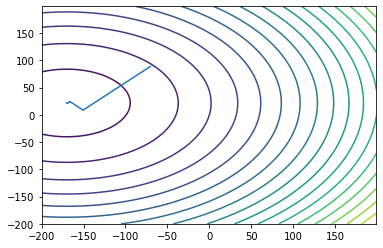

In [50]:
path_x = []
path_y = []

for xi, yi in result_fast[1]:
  path_x.append(xi)
  path_y.append(yi)

plt.contour(x, y, z, 20)
plt.plot(path_y, path_x)
#plt.axis([-0.005,0.005,-0.005,0.005])
plt.show()

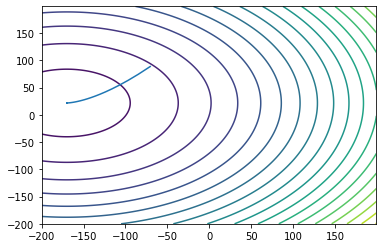

In [51]:
path_x = []
path_y = []

for xi, yi in result_gradient[1]:
  path_x.append(xi)
  path_y.append(yi)

plt.contour(x, y, z, 20)
plt.plot(path_y, path_x)
plt.show()

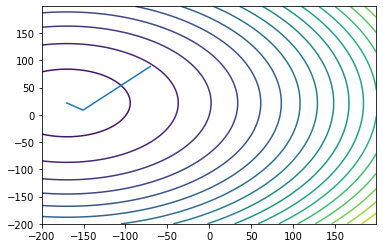

In [52]:
path_x = []
path_y = []

for xi, yi in result_conjugate[1]:
  path_x.append(xi)
  path_y.append(yi)

plt.contour(x, y, z, 20)
plt.plot(path_y, path_x)
plt.show()

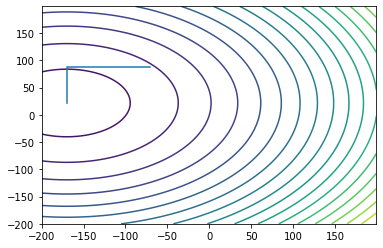

In [53]:
path_x = []
path_y = []

for xi, yi in result_powell[1]:
  path_x.append(xi)
  path_y.append(yi)

plt.contour(x, y, z, 20)
plt.plot(path_y, path_x)
plt.show()

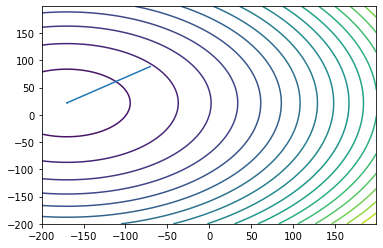

In [54]:
path_x = []
path_y = []

for xi, yi in result_newton[1]:
  path_x.append(xi)
  path_y.append(yi)

plt.contour(x, y, z, 20)
plt.plot(path_y, path_x)
plt.show()